In [1]:
pip install pandas numpy matplotlib tensorflow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
# Load dataset
data = pd.read_csv('/content/hindi_hope_train.csv')  # replace 'your_dataset.csv' with the actual path to your file


In [4]:

# Check for missing values
data.isnull().sum()

# Drop missing values
data.dropna(inplace=True)

# Clean the text
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.lower().strip()  # Lowercase and strip white spaces
    return text

data['cleaned_text'] = data['text'].apply(clean_text)

# Encode labels (Hope = 1, Not-Hope = 0)
label_encoder = LabelEncoder()
data['encoded_labels'] = label_encoder.fit_transform(data['Labels'])
# Print the dataset after preprocessing
print("Dataset after preprocessing:")
print(data[['text', 'cleaned_text', 'Labels', 'encoded_labels']].head(10))  # Print first 10 rows

Dataset after preprocessing:
                                                text  \
0                                 Syndrome bolte kya   
1  ❤️Har barr ek naye josh k sath ek achha😎 conte...   
2       She is trying to promote gangubai i think. 😂   
3                        Ye koi hasne ki baat ni hai   
4  Jo paidaish se ho wo accha insan hai but jo kh...   
5                                     ग्रेट हो सर आप   
6  Sir gay aur lesbian apni activities change kar...   
7                   @VIKASH SARMA  india, prayagraj.   
8  क्या बात है sir ji पहली बार in सब का मतलब समझ ...   
9                                        Ekdam khara   

                                        cleaned_text    Labels  encoded_labels  
0                                 syndrome bolte kya  Not-Hope               1  
1  har barr ek naye josh k sath ek achha content ...  Not-Hope               1  
2          she is trying to promote gangubai i think  Not-Hope               1  
3                        ye ko

In [5]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['cleaned_text'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(data['cleaned_text'])

In [6]:
# Padding sequences
max_len = 100  # Set max sequence length
X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
y = data['Labels'].values

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:

# 2. Load GloVe Embeddings
embedding_dim = 100  # or 200/300 based on GloVe model
embedding_index = {}
with open('/content/glove.6B.100d.txt', encoding='utf-8') as f:  # Ensure you have GloVe downloaded in the correct path
    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.array(values[1:], dtype='float32')
        embedding_index[word] = coefficients

In [8]:
# Create embedding matrix
vocab_size = len(word_index) + 1  # Add 1 for padding token
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# **CNN**

In [9]:
# 3. Build CNN Model
cnnmodel = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnnmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [10]:
# Ensure labels are correctly encoded as integers
data['Labels'] = data['Labels'].apply(lambda x: 1 if x == 'Hope' else 0).astype(int)

# Splitting data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
print(f"y_train type: {y_train.dtype}")
print(f"y_val type: {y_val.dtype}")


y_train type: object
y_val type: object


In [12]:
import pandas as pd

# Convert y_train and y_val to pandas Series
y_train = pd.Series(y_train)
y_val = pd.Series(y_val)

# Apply the conversion
y_train = y_train.apply(lambda x: 1 if x == 'Hope' else 0)
y_val = y_val.apply(lambda x: 1 if x == 'Hope' else 0)


In [13]:
y_train = y_train.astype(int)
y_val = y_val.astype(int)


In [14]:
print(f"y_train type: {y_train.dtype}")
print(f"y_val type: {y_val.dtype}")


y_train type: int64
y_val type: int64


In [15]:
print(f"y_train values: {y_train.unique()}")
print(f"y_val values: {y_val.unique()}")

y_train values: [0 1]
y_val values: [0 1]


In [23]:
cnnhistory = cnnmodel.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9905 - loss: 0.0289 - val_accuracy: 0.8555 - val_loss: 0.9462
Epoch 2/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9922 - loss: 0.0235 - val_accuracy: 0.8672 - val_loss: 0.9516
Epoch 3/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9926 - loss: 0.0224 - val_accuracy: 0.8828 - val_loss: 1.1444
Epoch 4/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9916 - loss: 0.0283 - val_accuracy: 0.8555 - val_loss: 0.9408
Epoch 5/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9928 - loss: 0.0258 - val_accuracy: 0.8633 - val_loss: 1.0174
Epoch 6/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9918 - loss: 0.0307 - val_accuracy: 0.8652 - val_loss: 1.0649
Epoch 7/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9924 - loss: 0.0213 - val_accuracy: 0.8652 - val_loss: 1.0989
Epoch 8/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9944 - loss: 0.0188 - val_accuracy: 0.8672 - v

In [24]:
# 5. Final Accuracy and Loss on Training and Validation Data
train_acc = cnnhistory.history['accuracy'][-1]
val_acc = cnnhistory.history['val_accuracy'][-1]
train_loss = cnnhistory.history['loss'][-1]
val_loss = cnnhistory.history['val_loss'][-1]

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")



Final Training Accuracy: 0.9932
Final Validation Accuracy: 0.8691
Final Training Loss: 0.0228
Final Validation Loss: 1.1948


In [25]:
from sklearn.metrics import classification_report

# 1. Predict on validation data
y_val_pred_prob = cnnmodel.predict(X_val)  # Get probabilities
y_val_pred = (y_val_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# 2. Generate classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=['No Hope', 'Hope']))


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Classification Report:
              precision    recall  f1-score   support

     No Hope       0.91      0.95      0.93       456
        Hope       0.36      0.25      0.29        56

    accuracy                           0.87       512
   macro avg       0.64      0.60      0.61       512
weighted avg       0.85      0.87      0.86       512



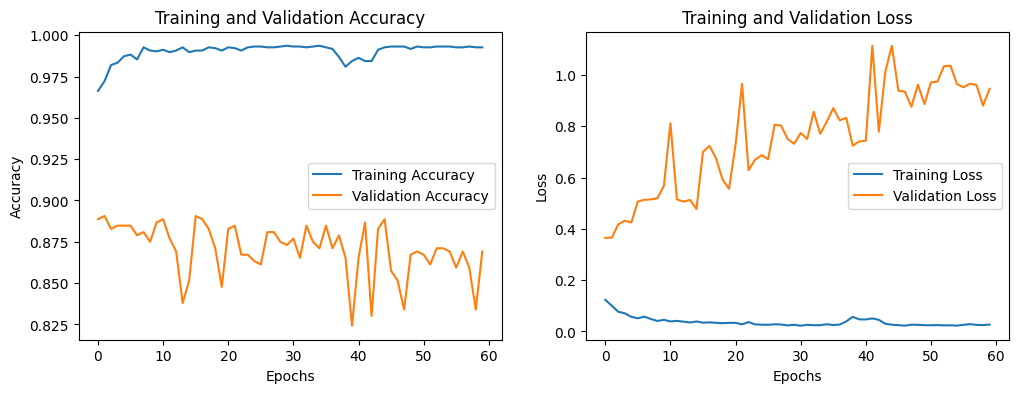

In [21]:
# 5. Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(cnnhistory.history['accuracy'], label='Training Accuracy')
plt.plot(cnnhistory.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(cnnhistory.history['loss'], label='Training Loss')
plt.plot(cnnhistory.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

# **RNN**

In [26]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
# 3. Build RNN Model (with LSTM layers)
rnnmodel = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

rnnmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
rnnmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
#  Train the model
rnnhistory = rnnmodel.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 384ms/step - accuracy: 0.8640 - loss: 0.5140 - val_accuracy: 0.8906 - val_loss: 0.3442
Epoch 2/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 361ms/step - accuracy: 0.8593 - loss: 0.4077 - val_accuracy: 0.8711 - val_loss: 0.3335
Epoch 3/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 34s 246ms/step - accuracy: 0.8483 - loss: 0.4008 - val_accuracy: 0.8867 - val_loss: 0.3207
Epoch 4/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 236ms/step - accuracy: 0.8498 - loss: 0.4047 - val_accuracy: 0.8906 - val_loss: 0.3193
Epoch 5/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 299ms/step - accuracy: 0.8578 - loss: 0.4022 - val_accuracy: 0.8906 - val_loss: 0.3394
Epoch 6/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.8570 - loss: 0.4232 - val_accuracy: 0.8906 - val_loss: 0.3473
Epoch 7/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 235ms/step - accuracy: 0.8557 - loss: 0.4316 - val_accuracy: 0.8906 - val_loss: 0.3505
Epoch 8/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 237ms/step - accuracy: 0.8596 - loss: 0.4161 - val_accu

In [29]:
# 5. Final Accuracy and Loss on Training and Validation Data
train_acc = rnnhistory.history['accuracy'][-1]
val_acc = rnnhistory.history['val_accuracy'][-1]
train_loss = rnnhistory.history['loss'][-1]
val_loss = rnnhistory.history['val_loss'][-1]

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

Final Training Accuracy: 0.9683
Final Validation Accuracy: 0.8633
Final Training Loss: 0.1377
Final Validation Loss: 0.4503


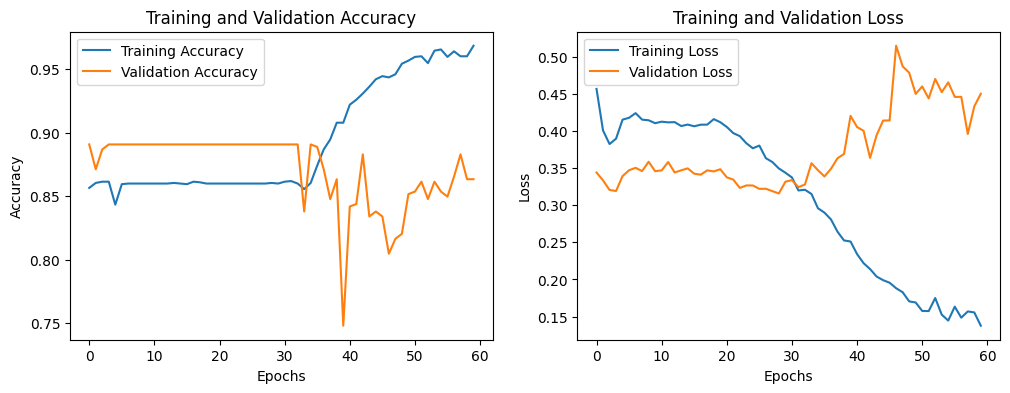

In [30]:
# 5. Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(rnnhistory.history['accuracy'], label='Training Accuracy')
plt.plot(rnnhistory.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(rnnhistory.history['loss'], label='Training Loss')
plt.plot(rnnhistory.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

# **LSTM**

In [31]:
# 3. Build LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [32]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
# 4. Train the model
lstmhistory = lstm_model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 248ms/step - accuracy: 0.8506 - loss: 0.5003 - val_accuracy: 0.8906 - val_loss: 0.3470
Epoch 2/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 240ms/step - accuracy: 0.8609 - loss: 0.3951 - val_accuracy: 0.8906 - val_loss: 0.3457
Epoch 3/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 240ms/step - accuracy: 0.8591 - loss: 0.4162 - val_accuracy: 0.8906 - val_loss: 0.4304
Epoch 4/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 239ms/step - accuracy: 0.8731 - loss: 0.4216 - val_accuracy: 0.8906 - val_loss: 0.3449
Epoch 5/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 238ms/step - accuracy: 0.8602 - loss: 0.4386 - val_accuracy: 0.8906 - val_loss: 0.3300
Epoch 6/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 239ms/step - accuracy: 0.8668 - loss: 0.4077 - val_accuracy: 0.8906 - val_loss: 0.3336
Epoch 7/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 243ms/step - accuracy: 0.8566 - loss: 0.4159 - val_accuracy: 0.8906 - val_loss: 0.3501
Epoch 8/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 241ms/step - accuracy: 0.8667 - loss: 0.4128 - val_accu

In [34]:
# 5. Final Accuracy and Loss on Training and Validation Data
train_acc = lstmhistory.history['accuracy'][-1]
val_acc = lstmhistory.history['val_accuracy'][-1]
train_loss = lstmhistory.history['loss'][-1]
val_loss = lstmhistory.history['val_loss'][-1]

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

Final Training Accuracy: 0.8691
Final Validation Accuracy: 0.8887
Final Training Loss: 0.3039
Final Validation Loss: 0.3355


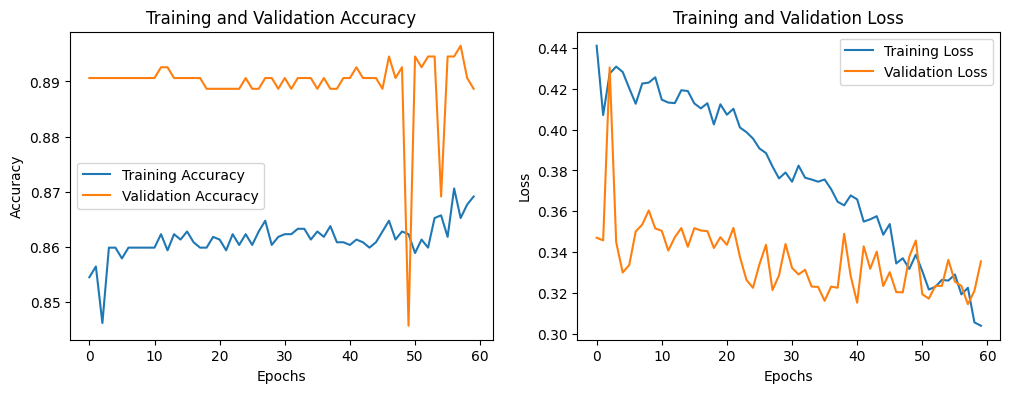

In [35]:
# 5. Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(lstmhistory.history['accuracy'], label='Training Accuracy')
plt.plot(lstmhistory.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(lstmhistory.history['loss'], label='Training Loss')
plt.plot(lstmhistory.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

# **Bi-LSTM**

In [36]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
# 3. Build Bi-LSTM Model
bi_lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [37]:
bi_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
# 4. Train the model
bi_lstmhistory = bi_lstm_model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 579ms/step - accuracy: 0.8359 - loss: 0.5011 - val_accuracy: 0.8887 - val_loss: 0.3185
Epoch 2/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 608ms/step - accuracy: 0.8556 - loss: 0.3881 - val_accuracy: 0.8906 - val_loss: 0.3437
Epoch 3/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 567ms/step - accuracy: 0.8562 - loss: 0.3522 - val_accuracy: 0.8906 - val_loss: 0.3367
Epoch 4/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 571ms/step - accuracy: 0.8644 - loss: 0.3479 - val_accuracy: 0.8906 - val_loss: 0.3241
Epoch 5/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 565ms/step - accuracy: 0.8735 - loss: 0.3424 - val_accuracy: 0.8887 - val_loss: 0.3162
Epoch 6/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 600ms/step - accuracy: 0.8664 - loss: 0.3383 - val_accuracy: 0.8926 - val_loss: 0.3019
Epoch 7/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 567ms/step - accuracy: 0.8566 - loss: 0.3303 - val_accuracy: 0.8906 - val_loss: 0.3049
Epoch 8/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 572ms/step - accuracy: 0.8793 - loss: 0.3093 - val_accu

In [39]:
# 5. Final Accuracy and Loss on Training and Validation Data
train_acc = bi_lstmhistory.history['accuracy'][-1]
val_acc = bi_lstmhistory.history['val_accuracy'][-1]
train_loss = bi_lstmhistory.history['loss'][-1]
val_loss = bi_lstmhistory.history['val_loss'][-1]

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

Final Training Accuracy: 0.9814
Final Validation Accuracy: 0.8672
Final Training Loss: 0.0558
Final Validation Loss: 0.7099


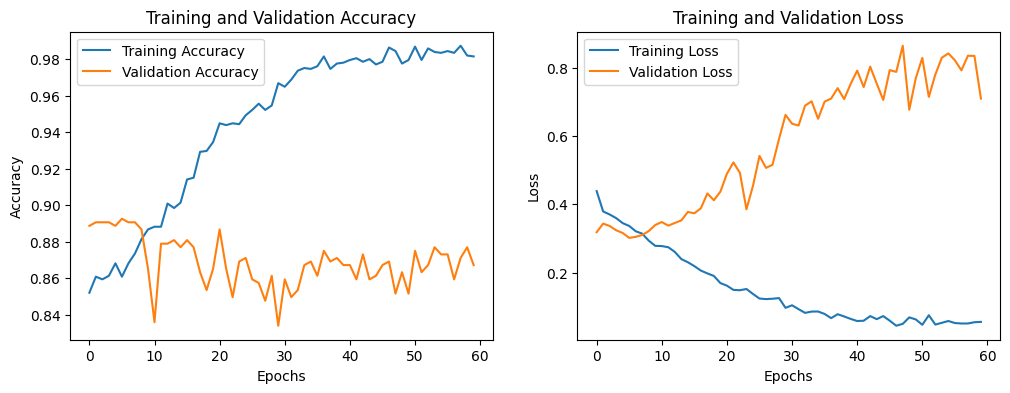

In [40]:
# 5. Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(bi_lstmhistory.history['accuracy'], label='Training Accuracy')
plt.plot(bi_lstmhistory.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(bi_lstmhistory.history['loss'], label='Training Loss')
plt.plot(bi_lstmhistory.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

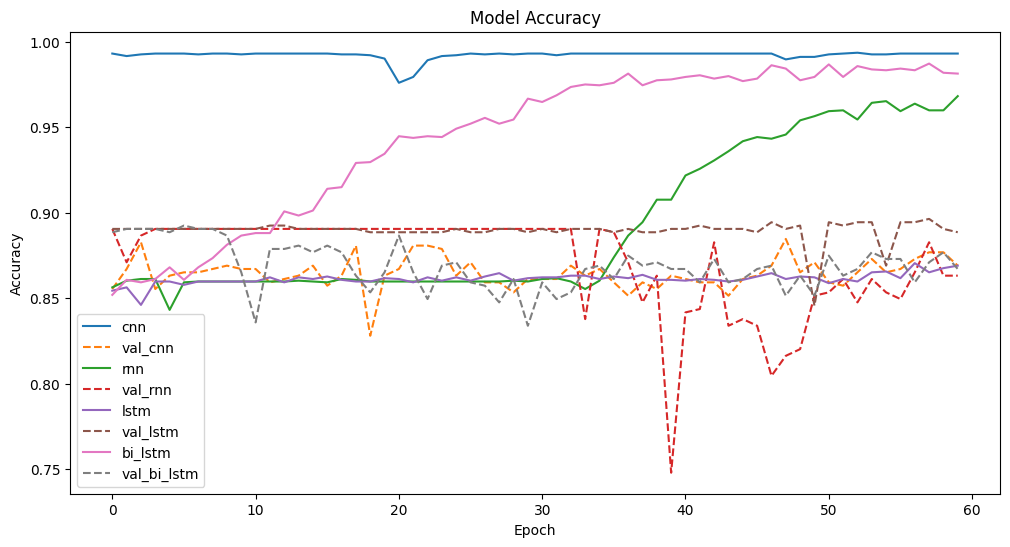

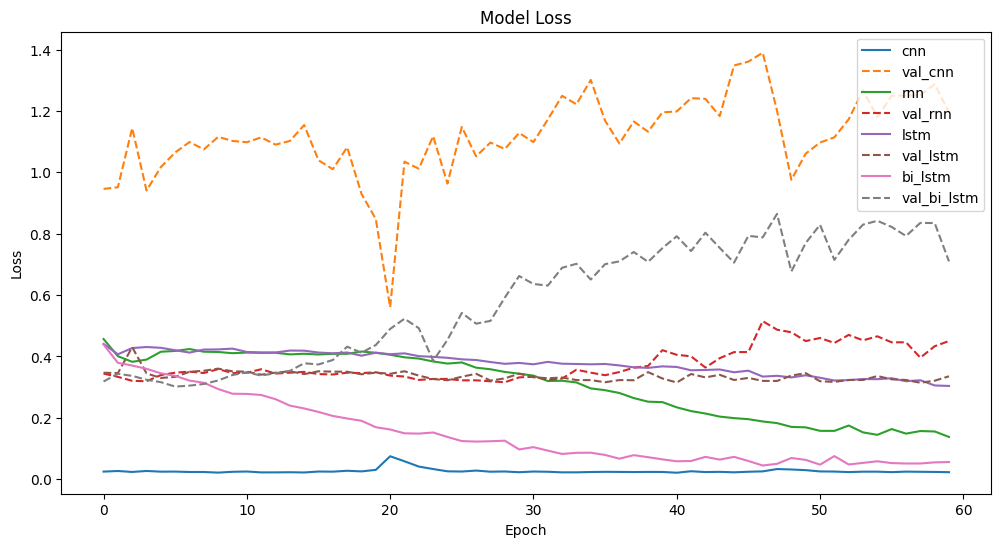

In [41]:
import matplotlib.pyplot as plt

# Function to plot history
def plot_history(histories, key='accuracy'):
    plt.figure(figsize=(12, 6))
    for name, history in histories.items():
        plt.plot(history.history[key], label=name)
        plt.plot(history.history[f'val_{key}'], linestyle='--', label=f'val_{name}')
    plt.title(f'Model {key.capitalize()}')
    plt.ylabel(key.capitalize())
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# Plot accuracies
histories = {
    'cnn': cnnhistory,
    'rnn': rnnhistory,
    'lstm': lstmhistory,
    'bi_lstm': bi_lstmhistory
}
plot_history(histories, key='accuracy')

# Plot losses
plot_history(histories, key='loss')



In [42]:
# Comparison table
comparison = pd.DataFrame({
    'Model': ['CNN', 'RNN', 'LSTM', 'Bi-LSTM'],
    'Accuracy': [
        cnnhistory.history['accuracy'][-1],
        rnnhistory.history['accuracy'][-1],
        lstmhistory.history['accuracy'][-1],
        bi_lstmhistory.history['accuracy'][-1]
    ]
})

print(comparison)


     Model  Accuracy
0      CNN  0.993164
1      RNN  0.968262
2     LSTM  0.869141
3  Bi-LSTM  0.981445


In [43]:
from sklearn.metrics import classification_report

models = {'CNN': cnnmodel, 'RNN': rnnmodel, 'LSTM': lstm_model, 'Bi-LSTM': bi_lstm_model}

for model_name, model in models.items():
    print(f"Classification Report for {model_name}:")
    y_pred_prob = model.predict(X_val)
    y_pred = (y_pred_prob > 0.5).astype(int)
    print(classification_report(y_val, y_pred, target_names=['No Hope', 'Hope']))


Classification Report for CNN:
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
              precision    recall  f1-score   support

     No Hope       0.91      0.95      0.93       456
        Hope       0.36      0.25      0.29        56

    accuracy                           0.87       512
   macro avg       0.64      0.60      0.61       512
weighted avg       0.85      0.87      0.86       512

Classification Report for RNN:
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
              precision    recall  f1-score   support

     No Hope       0.91      0.94      0.92       456
        Hope       0.33      0.25      0.29        56

    accuracy                           0.86       512
   macro avg       0.62      0.59      0.61       512
weighted avg       0.85      0.86      0.85       512

Classification Report for LSTM:
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
              precision    recall  f1-score   support

     No Hope       0.90      0.99      0.94       456
        Hope       0.43